In [49]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
from collections import Counter
import pprint as pp

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [50]:
import pandas as pd
from datetime import datetime as dt
from pymongo import MongoClient as mc

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)
keti_db = client.keti_pattern_recognition

household_col = keti_db.household_info
cluster_col = keti_db.cluster_info
weather_col = keti_db.weather_info

In [51]:
wt_db_datas = weather_col.find()
wt_datas = pd.DataFrame()

for wt in wt_db_datas:
    tmp = pd.DataFrame()
    tmp['date'] = [wt['date']]
    tmp['weather'] = [wt['weather']]
    tmp['avg_ta'] = float(wt['avgTa'])
    tmp['avg_rhm'] = float(wt['avgRhm'])
    
    wt_datas = pd.concat([wt_datas, tmp])

# 영하 온도 전처리
min_ta = min(wt_datas['avg_ta'])
wt_datas['avg_ta'] += (min_ta * -1 + 1)

# weather 정수 인코딩
weather_count = Counter(wt_datas['weather'])
weather_integer = dict()
rank = 1
for key, count in weather_count.most_common():
    weather_integer[key] = rank
    rank += 1
pp.pprint(weather_integer)
wt_datas['weather_no'] = [weather_integer[weather] for weather in wt_datas['weather']]
wt_datas

def get_season_no(month):
    if month in [3,4,5]:
        return 1 # 봄
    elif month in [6,7,8]:
        return 2 # 여름
    elif month in [9,10,11]:
        return 3 # 가을
    elif month in [12,1,2]:
        return 4 # 겨울
    
# Date, Season Utils
wt_datas['season_no'] = [get_season_no(weather.month) for weather in wt_datas['date']] 
wt_datas['day_no'] = [weather.weekday() + 1 for weather in wt_datas['date']] 

sample_weather_col = ['season_no','day_no','weather_no','avg_ta', 'avg_rhm']
sample_weather_col_2 = ['date','season_no','day_no','weather','weather_no','avg_ta', 'avg_rhm']
wt_datas[sample_weather_col_2]

{'눈': 5,
 '박무': 4,
 '비': 3,
 '소나기': 7,
 '안개': 10,
 '안개비': 11,
 '연무': 2,
 '진눈깨비': 12,
 '채운': 8,
 '특이사항 없음': 1,
 '햇무리': 6,
 '황사': 9}


,date,season_no,day_no,weather,weather_no,avg_ta,avg_rhm
0,2018-05-01,1,2,연무,2,31.9,72.8
0,2018-05-02,1,3,비,3,26.6,90.4
0,2018-05-03,1,4,비,3,22.7,62.4
0,2018-05-04,1,5,특이사항 없음,1,25.6,45.5
0,2018-05-05,1,6,특이사항 없음,1,29.8,46.8
...,...,...,...,...,...,...,...
0,2019-04-26,1,5,비,3,19.9,82.1
0,2019-04-27,1,6,햇무리,6,23.1,52.6
0,2019-04-28,1,7,비,3,24.4,48.8
0,2019-04-29,1,1,햇무리,6,24.5,52.9


array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

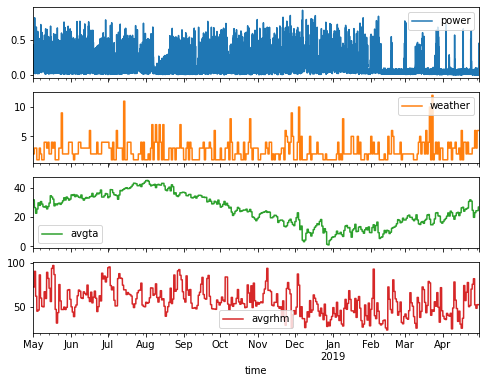

In [52]:
uid = "아파트4-103-106"
hh_db_datas = household_col.find_one({"uid": uid})
hh_db_datas
date_wt_datas = wt_datas.set_index(['date'])

uid_in, timeslot = hh_db_datas['uid'], hh_db_datas['timeslot']
datas = pd.DataFrame(columns=['power', 'weather', 'avgta', 'avgrhm'])
datas['power'] = [ts['power'] for ts in timeslot]
datas['weather'] = [date_wt_datas.loc[ts['time'].split(" ")[0]]['weather_no'] for ts in timeslot]
datas['avgta'] = [date_wt_datas.loc[ts['time'].split(" ")[0]]['avg_ta'] for ts in timeslot]
datas['avgrhm'] = [date_wt_datas.loc[ts['time'].split(" ")[0]]['avg_rhm'] for ts in timeslot]
datas.index = [dt.strptime(ts['time'], "%Y-%m-%d T%H:%M %z") for ts in timeslot]
datas.index.name = "time"
datas.head()
datas.plot(subplots=True)


In [53]:
dataset = datas.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

# 표준화
dataset = (dataset-data_mean)/data_std
dataset

array([[-0.10674379, -0.33892389,  0.37834841,  0.90624847],
       [-0.06885632, -0.33892389,  0.37834841,  0.90624847],
       [-0.24882183, -0.33892389,  0.37834841,  0.90624847],
       ...,
       [-0.68452779,  1.94986522, -0.07532896, -0.4512921 ],
       [-0.69399966,  1.94986522, -0.07532896, -0.4512921 ],
       [-0.73188714,  1.94986522, -0.07532896, -0.4512921 ]])

In [54]:
def multivariate_data(dataset, target, start_index, end_index, 
                      history_size, target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
        
        
    return np.array(data), np.array(labels)

In [55]:
past_history = 96
future_target = 48
STEP = 4

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                  TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True
                                                  )
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                                  TRAIN_SPLIT, None, past_history,
                                                   future_target, STEP,
                                                   single_step=True
                                                  )

In [56]:
print("Single window of past history : {}".format(x_train_single[0].shape))

Single window of past history : (24, 4)


- 24 : 1일 * 24시간
- 4 : 4개의 특성

In [57]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [58]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(
    tf.keras.layers.LSTM(32,
                        input_shape=x_train_single.shape[-2:])
)
single_step_model.add(
    tf.keras.layers.Dense(1)
)
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4736      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [59]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 300

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                           steps_per_epoch=EVALUATION_INTERVAL,
                                           validation_data=val_data_single,
                                           validation_steps=50)

Epoch 1/300
200/200 [==============================] - 4s 15ms/step - loss: 0.5279 - val_loss: 0.5245
Epoch 2/300
200/200 [==============================] - 3s 13ms/step - loss: 0.4361 - val_loss: 0.4737
Epoch 3/300
200/200 [==============================] - 3s 13ms/step - loss: 0.4048 - val_loss: 0.4743
Epoch 4/300
200/200 [==============================] - 3s 14ms/step - loss: 0.3870 - val_loss: 0.4666
Epoch 5/300
200/200 [==============================] - 3s 13ms/step - loss: 0.3753 - val_loss: 0.4827
Epoch 6/300
200/200 [==============================] - 3s 13ms/step - loss: 0.3661 - val_loss: 0.4757
Epoch 7/300
200/200 [==============================] - 3s 13ms/step - loss: 0.3575 - val_loss: 0.4751
Epoch 8/300
200/200 [==============================] - 3s 14ms/step - loss: 0.3504 - val_loss: 0.4782
Epoch 9/300
200/200 [==============================] - 3s 14ms/step - loss: 0.3484 - val_loss: 0.4689
Epoch 10/300
200/200 [==============================] - 3s 14ms/step - loss: 0.342

200/200 [==============================] - 3s 17ms/step - loss: 0.2275 - val_loss: 0.4463
Epoch 81/300
200/200 [==============================] - 3s 15ms/step - loss: 0.2269 - val_loss: 0.4358
Epoch 82/300
200/200 [==============================] - 3s 16ms/step - loss: 0.2265 - val_loss: 0.4450
Epoch 83/300
200/200 [==============================] - 3s 16ms/step - loss: 0.2261 - val_loss: 0.4385
Epoch 84/300
200/200 [==============================] - 3s 15ms/step - loss: 0.2254 - val_loss: 0.4425
Epoch 85/300
200/200 [==============================] - 3s 17ms/step - loss: 0.2251 - val_loss: 0.4397
Epoch 86/300
200/200 [==============================] - 3s 17ms/step - loss: 0.2223 - val_loss: 0.4440
Epoch 87/300
200/200 [==============================] - 3s 17ms/step - loss: 0.2251 - val_loss: 0.4423
Epoch 88/300
200/200 [==============================] - 3s 15ms/step - loss: 0.2224 - val_loss: 0.4435
Epoch 89/300
200/200 [==============================] - 3s 15ms/step - loss: 0.2235 - 

200/200 [==============================] - 4s 18ms/step - loss: 0.1678 - val_loss: 0.4554
Epoch 160/300
200/200 [==============================] - 3s 16ms/step - loss: 0.1685 - val_loss: 0.4587
Epoch 161/300
200/200 [==============================] - 3s 15ms/step - loss: 0.1686 - val_loss: 0.4618
Epoch 162/300
200/200 [==============================] - 3s 14ms/step - loss: 0.1694 - val_loss: 0.4636
Epoch 163/300
200/200 [==============================] - 2s 11ms/step - loss: 0.1666 - val_loss: 0.4622
Epoch 164/300
200/200 [==============================] - 2s 10ms/step - loss: 0.1661 - val_loss: 0.4710
Epoch 165/300
200/200 [==============================] - 2s 10ms/step - loss: 0.1681 - val_loss: 0.4648
Epoch 166/300
200/200 [==============================] - 2s 10ms/step - loss: 0.1664 - val_loss: 0.4616
Epoch 167/300
200/200 [==============================] - 2s 9ms/step - loss: 0.1667 - val_loss: 0.4661
Epoch 168/300
200/200 [==============================] - 2s 9ms/step - loss: 0.

Epoch 238/300
200/200 [==============================] - 2s 10ms/step - loss: 0.1536 - val_loss: 0.4796
Epoch 239/300
200/200 [==============================] - 3s 14ms/step - loss: 0.1498 - val_loss: 0.4879
Epoch 240/300
200/200 [==============================] - 3s 13ms/step - loss: 0.1517 - val_loss: 0.4859


In [ ]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    
    plt.show()

In [ ]:
plot_train_history(single_step_history,
                  "Single Step Training and validation loss")

In [ ]:
for x,y in val_data_single.take(3):
    plot = show_plot([x[0][:,1].numpy(), y[0].numpy(),
                     single_step_model.predict(x)[0]], 12,
                    'Single Step Prediction')
    plot.show()